# Momentum

Authors : Pierre Ablin & Robert Gower

We're interested in minimizing the Rosenbrock function

$f(x_1, x_2) = 100(x_1 - x_2^2)^2 + (1 - x_2)^2$

**Question** : is it a convex function? What it its minimum?

In [14]:
import numpy as np
from numpy import linalg as LA
from ipywidgets import interact, fixed
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import rosen as f
from scipy.optimize import rosen_der as fp
from scipy.optimize import rosen_hess as fpp
from scipy.optimize import line_search
from scipy.optimize import minimize

fontsize = 18
params = {
      'axes.titlesize': fontsize + 4,
      'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': True}
plt.rcParams.update(params)

In [15]:
x0 = np.zeros(2)
res = minimize(f, x0, method='BFGS', jac=fp,
                options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25


In [16]:
sol = res.x
print(sol)

[1. 1.]


In [41]:
def GD_mom(x0, max_iter,momentum=0.0):
    x = x0.copy()
    x_old = x.copy()
    x_l = []
    for i in range(max_iter):
        gradient = fp(x)
        x_l.append(x.copy())
        hess = fpp(x)
        L1 = LA.norm(hess, 2)
        stepsize =2./L1
        direction = -stepsize*gradient + momentum*(x-x_old)
        x_old = x.copy()
        x += direction
    return np.array(x_l)

In [42]:
def plot(f, x_l=None,axe=None, title='Rosenbrock function', quad=None, level=1):
    if axe is None:
        fig, axe = plt.subplots(1, 1, figsize=(8, 8))
    X1, X2 = np.meshgrid(np.linspace(-3, 3, 200),
                     np.linspace(-1, 3, 200))
    Z = f([X1, X2])
    levels = np.logspace(-6, 4, 40)
    axe.contourf(X1, X2, np.log(Z + 0.001), levels=np.log(levels + 0.001), cmap=plt.cm.Oranges_r)
    #Plot solution
    axe.plot(1.0, 1.0, 'o', markersize=15, markeredgewidth=3, color = "green")
    if x_l is not None:
        x1, x2 = x_l.T
        axe.plot(x1, x2, 'b', linewidth=3)
        axe.plot(x1, x2, 'k+', markersize=10, markeredgewidth=3)
        if quad is not None:
            Z_q = quad([X1, X2])
            levels = 100 * (level / 100) ** np.array([1.5, 1, 0.8])
            levels[-1] += 1.
            levels[0] /=2
            axe.contour(X1, X2, Z_q, levels=levels, colors=['k'])
    axe.set_title(title)

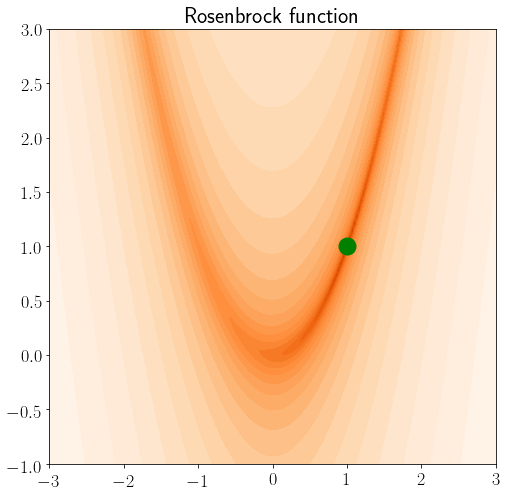

In [43]:
plot(f)

Function value 3.824211500353585


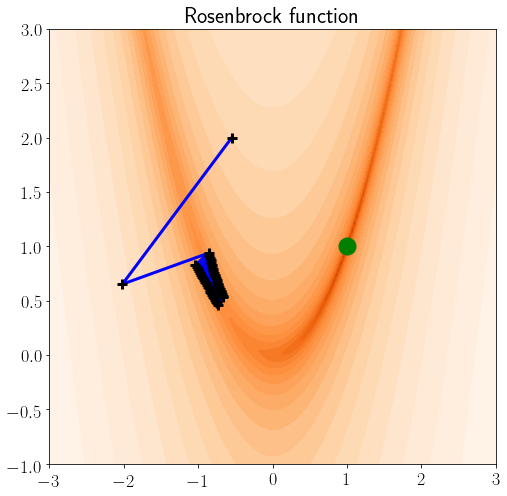

In [44]:
x0 = np.zeros(2)
x0[0] = -0.55
x0[1] = 2.0
xl = GD_mom(x0, 50)
plot(f, xl)
print("Function value", f(xl[-1]))

Function value 0.023590714495543084


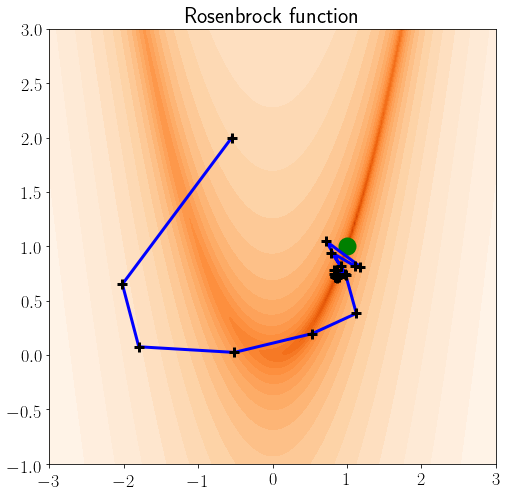

In [45]:
xl = GD_mom(x0, 30,0.64)
plot(f, xl)
print("Function value", f(xl[-1]))

# A bad example of Stochastic Heavey ball. Better example here:
# http://fa.bianp.net/teaching/2018/COMP-652/stochastic_gradient.html

In [46]:
# def f(x,i):
#     if (i==1):
#         out = 100*(x[0]-x[1]**2)**2
#     else:
#         out = (1-x[1])**2
#     return out

def fps(x,i):
    g = np.zeros(2)
    if (i==1):
        fact = 200*(x[0]-x[1]**2) 
        g[0] = fact 
        g[1] = -2*x[1]*fact
    else:
        fact = 2*(1-x[1])         
        g[0] = 0.0
        g[1] = -fact
    return g

In [48]:
def SGD_mom(x0, max_iter,momentum =0.0):
    x = x0.copy()
    x_old = x.copy()
    x_l = []
    iis = np.random.randint(0, 2, max_iter) # generate indices of random samples
    for i in range(max_iter):
        j = iis[i]
        gradient = fps(x,j)
        x_l.append(x.copy())
        hess = fpp(x)
        L1 = LA.norm(hess, 2)
        stepsize =0.1/L1
        # Compute the search direction 
        direction = -stepsize*gradient + momentum*(x-x_old)
        x_old = x.copy()
        x += direction
    return np.array(x_l)

Function value 22.656972132038717


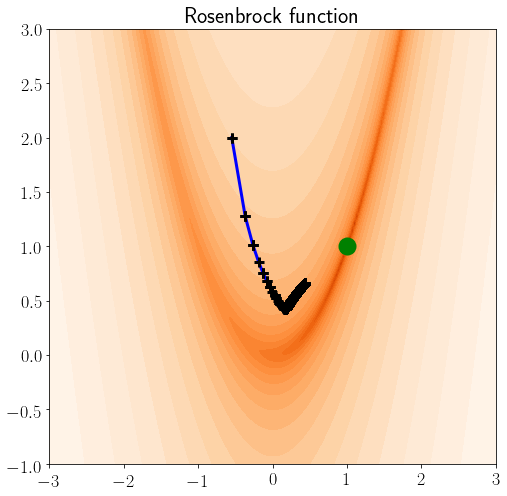

In [69]:
x0 = np.zeros(2)
x0[0] = -0.55
x0[1] = 2.0
xl = SGD_mom(x0, 3000,0.0)
plot(f, xl)
print("Function value", f(xl[-1]))

Function value 19.130484122998762


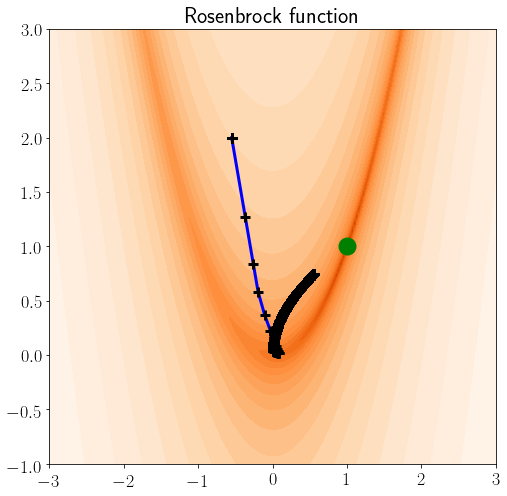

In [70]:
x0 = np.zeros(2)
x0[0] = -0.55
x0[1] = 2.0
xl = SGD_mom(x0, 3000,0.6)
plot(f, xl)
print("Function value", f(xl[-1]))

# JUNK!

In [ ]:


def GD_mom_optimal(x0, max_iter,stepsize,momentum):
    x = x0.copy()
    x_old = x.copy()
    x_l = []
    for i in range(max_iter):
        gradient = fp(x)
        x_l.append(x.copy())
        hess = fpp(x)
        L1 = LA.norm(hess, 2)
        w, v = LA.eig(hess)
        mu1 = np.min(w)
        stepsize =4/(np.sqrt(L1)+ np.sqrt(mu1))**2
        if(momentum != 0.0):
            momentum = (np.sqrt(L1)- np.sqrt(mu1))/(np.sqrt(L1)+ np.sqrt(mu1))
        # Compute the search direction 
#         print(mu1,L1,momentum)
        direction = -gradient + momentum*(x-x_old)
        stepsize =1.0;
#         stepsize = line_search(f, fp, x, -gradient, gradient, maxiter=1000, c1=0.0000001, c2=0.99)[0]
        x += stepsize*direction
#         x -= stepsize * gradient
#         x += momentum*(x-x_old)
        x_old = x.copy()
    return np.array(x_l)

In [ ]:
mu = 0.01
L=1
def f(x):
    return 0.5*mu*x[0]**2 + 0.5*L*x[1]**2

def fp(x):
    g = np.zeros(2)
    g[0] = mu*x[0]
    g[1] = L*x[1]
    return g
def fpp(x):
#     H = np.zeros((2,2))
#     H[0,0] = mu
#     H[1,1] = L
    H = np.matrix([[mu, 0], [0, L]])
    return H